<a href="https://colab.research.google.com/github/apester/PINN/blob/main/PINN_AdvectionDiffusion_MobileSensorInverse_UnknownSource_IMEX_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobile-Sensor Inverse PINN: 1D Advection–Diffusion with Unknown Source  
## Ground truth: IMEX (Explicit Upwind Advection + Crank–Nicolson Diffusion)

We solve the inverse problem
\[
c_t + u\,c_x = D\,c_{xx} + s(x,t),\qquad x\in(0,L),\ t\in[0,T],
\]
where the **source is unknown** and is learned as a neural network \(s_\phi(x,t)\).

We learn **two neural nets**:
- Solution: \(c_\theta(x,t)\)
- Source: \(s_\phi(x,t)\)

### Mobile sensor
We use a **single mobile sensor** that measures
\(\{(x(t_k), t_k, c(x(t_k), t_k))\}\) along a trajectory \(x(t)\).

Synthetic measurements are created from IMEX ground truth using a known Gaussian source
\((A,x_0,\sigma_x,t_0,\sigma_t)=(3,1,0.5,1,0.2)\) **only to generate data**. The PINN does **not** use this source form.

---
## Constants (kept the same as much as possible)
- \(L=2,\ N=1000,\ \Delta x=0.002\)
- \(u=1,\ D=\tfrac12\)
- IC: \(c(x,0)=x\)
- Dirichlet BCs: \(c(0,t)=0,\ c(L,t)=2\)


In [1]:
# =========================
# 0) Imports & Reproducibility
# =========================
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from dataclasses import dataclass
from typing import Callable, Tuple

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
# =========================
# 1) Configuration
# =========================
GT_SRC = (3.0, 1.0, 0.5, 1.0, 0.2)  # used ONLY for ground truth generation

@dataclass
class Params:
    # PDE
    L: float = 2.0
    N: int = 1000
    u: float = 1.0
    D: float = 0.5
    T: float = 2.0
    dt: float = 1e-3

    # Ground truth source params
    A: float = GT_SRC[0]
    x0: float = GT_SRC[1]
    sx: float = GT_SRC[2]
    t0: float = GT_SRC[3]
    st: float = GT_SRC[4]

    # IC/BC/collocation sizes
    n_f: int = 30000
    n_ic: int = 5000
    n_bc: int = 5000

    # Mobile sensor settings
    sensor_time_stride: int = 10      # sample every 10th time step
    sensor_noise_std: float = 0.01    # 0.0 for noiseless
    x_start: float = 0.1
    x_end: float = 1.9
    traj_period: float = 1.0          # seconds per back-and-forth cycle (triangular scan)

    # Training
    epochs: int = 8000
    lr: float = 1e-3
    print_every: int = 400

p = Params()

dx = p.L / p.N
cfl = abs(p.u) * p.dt / dx
mu  = p.D * p.dt / dx**2
print(f"dx={dx}, CFL={cfl}, mu={mu}")
assert cfl <= 1.0 + 1e-12, "CFL violated: reduce dt."


dx=0.002, CFL=0.5, mu=125.00000000000001


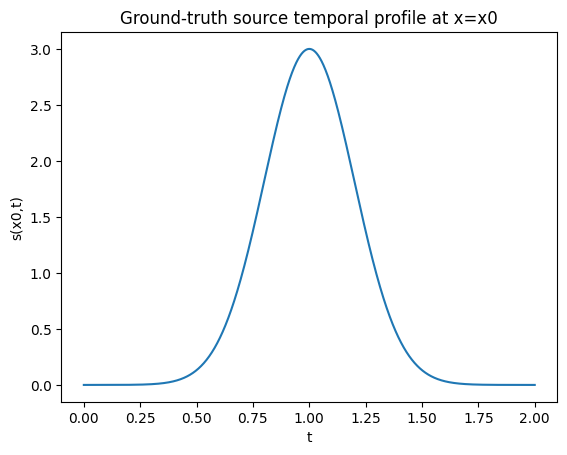

In [3]:
# =========================
# 2) Ground-truth Gaussian source (for synthetic data only)
# =========================
def gaussian_source_np(x: np.ndarray, t: float, A: float, x0: float, sx: float, t0: float, st: float) -> np.ndarray:
    return A * np.exp(-0.5 * ((x - x0) / sx)**2) * np.exp(-0.5 * ((t - t0) / st)**2)

ts = np.linspace(0, p.T, 2001)
s_peak = p.A * np.exp(-0.5 * ((ts - p.t0) / p.st)**2)
plt.figure()
plt.plot(ts, s_peak)
plt.xlabel('t'); plt.ylabel('s(x0,t)')
plt.title('Ground-truth source temporal profile at x=x0')
plt.show()


## 3) Ground truth solver (IMEX: explicit upwind advection + implicit CN diffusion)

Shapes: (1001,) (2001,) (2001, 1001)


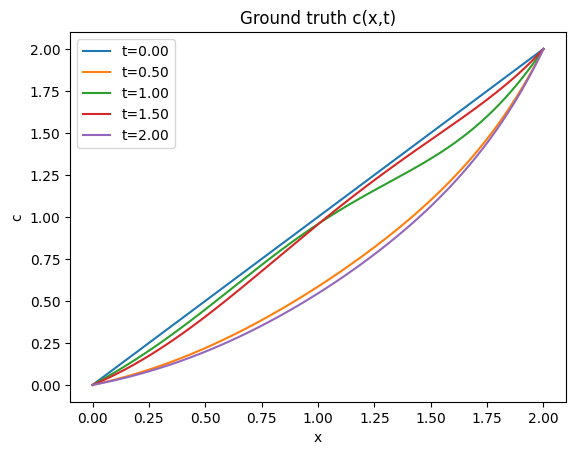

In [4]:
# =========================
# 3) Thomas algorithm + IMEX solver
# =========================
def thomas_solve(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    m = b.size
    cp = np.empty(m-1, dtype=float)
    dp = np.empty(m, dtype=float)

    denom = b[0]
    cp[0] = c[0] / denom
    dp[0] = d[0] / denom

    for i in range(1, m-1):
        denom = b[i] - a[i-1] * cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1] * dp[i-1]) / denom

    denom = b[m-1] - a[m-2] * cp[m-2] if m > 1 else b[m-1]
    dp[m-1] = (d[m-1] - (a[m-2] * dp[m-2] if m > 1 else 0.0)) / denom

    x = np.empty(m, dtype=float)
    x[m-1] = dp[m-1]
    for i in range(m-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x


def solve_imex_cn_upwind_with_source(
    L: float, N: int, u: float, D: float, T: float, dt: float,
    source_fn: Callable[[np.ndarray, float], np.ndarray],
    g0_fn: Callable[[float], float],
    gL_fn: Callable[[float], float],
    ic_fn: Callable[[np.ndarray], np.ndarray],
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dx = L / N
    Nt = int(np.round(T / dt))
    t = np.linspace(0.0, Nt * dt, Nt + 1)
    x = np.linspace(0.0, L, N + 1)

    lam = u * dt / dx
    mu = D * dt / dx**2

    C = np.zeros((Nt + 1, N + 1), dtype=float)
    C[0, :] = ic_fn(x)
    C[0, 0] = g0_fn(0.0)
    C[0, -1] = gL_fn(0.0)

    m = N - 1
    a = (-mu/2.0) * np.ones(m - 1)
    b = (1.0 + mu) * np.ones(m)
    c = (-mu/2.0) * np.ones(m - 1)

    for n in range(Nt):
        tn = t[n]
        tnp1 = t[n + 1]

        C[n, 0] = g0_fn(tn)
        C[n, -1] = gL_fn(tn)

        # explicit upwind advection
        if u >= 0:
            Aadv = lam * (C[n, 1:N] - C[n, 0:N-1])
        else:
            Aadv = lam * (C[n, 2:N+1] - C[n, 1:N])

        # explicit source at time n
        S = source_fn(x[1:N], tn)

        rhs = (1.0 - mu) * C[n, 1:N] + (mu/2.0) * (C[n, 0:N-1] + C[n, 2:N+1]) - Aadv + dt * S

        # Dirichlet BC at time n+1 shifts RHS
        c0_np1 = g0_fn(tnp1)
        cL_np1 = gL_fn(tnp1)
        rhs[0]  += (mu/2.0) * c0_np1
        rhs[-1] += (mu/2.0) * cL_np1

        interior = thomas_solve(a, b, c, rhs)

        C[n + 1, 0] = c0_np1
        C[n + 1, 1:N] = interior
        C[n + 1, -1] = cL_np1

    return x, t, C


g0 = lambda tt: 0.0
gL = lambda tt: p.L
ic = lambda xx: xx
source_gt = lambda xarr, tt: gaussian_source_np(xarr, tt, p.A, p.x0, p.sx, p.t0, p.st)

x, t, C = solve_imex_cn_upwind_with_source(p.L, p.N, p.u, p.D, p.T, p.dt, source_gt, g0, gL, ic)
print('Shapes:', x.shape, t.shape, C.shape)

plt.figure()
for tt in [0.0, 0.5, 1.0, 1.5, 2.0]:
    idx = int(round(tt/p.dt))
    plt.plot(x, C[idx], label=f't={t[idx]:.2f}')
plt.xlabel('x'); plt.ylabel('c'); plt.title('Ground truth c(x,t)'); plt.legend()
plt.show()


## 4) Mobile sensor dataset (trajectory + synthetic measurements)

Mobile sensor dataset: (201, 2) (201, 1)


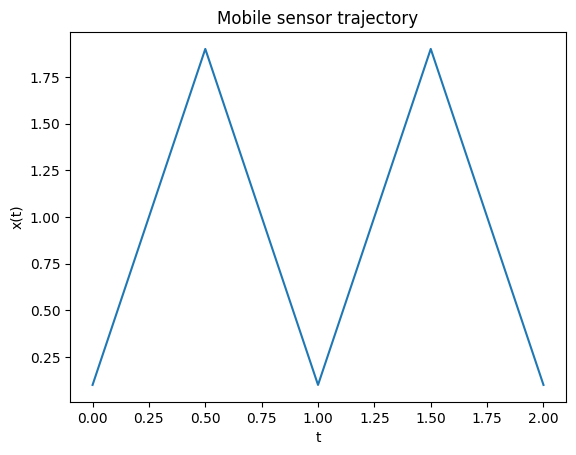

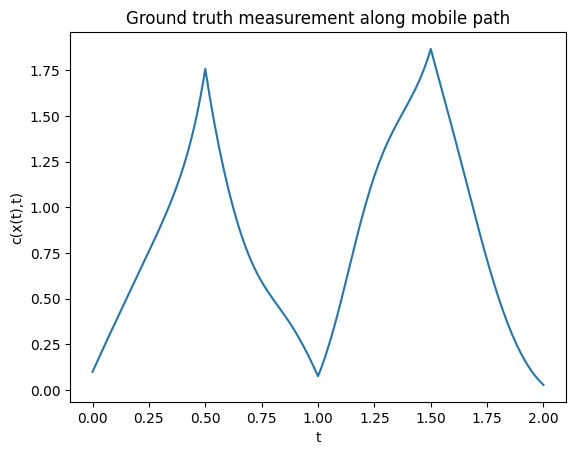

In [5]:
# =========================
# 4) Mobile sensor trajectory (triangular scan) + dataset
# =========================
def triangular_wave_01(phase: np.ndarray) -> np.ndarray:
    return np.where(phase < 0.5, 2.0*phase, 2.0*(1.0 - phase))

def x_traj(tvals: np.ndarray, x_start: float, x_end: float, period: float) -> np.ndarray:
    phase = (tvals / period) % 1.0
    w = triangular_wave_01(phase)  # in [0,1]
    return x_start + (x_end - x_start) * w

def interp_c_at_x(C_t: np.ndarray, xgrid: np.ndarray, xq: float) -> float:
    return float(np.interp(xq, xgrid, C_t))

def generate_mobile_sensor_dataset(
    xgrid: np.ndarray,
    tgrid: np.ndarray,
    Cgrid: np.ndarray,
    time_stride: int,
    x_start: float,
    x_end: float,
    period: float,
    noise_std: float = 0.0
):
    tidx = np.arange(0, tgrid.size, time_stride, dtype=int)
    t_s = tgrid[tidx]
    x_s = x_traj(t_s, x_start, x_end, period)

    X_list, Y_list = [], []
    for ti, tt, xq in zip(tidx, t_s, x_s):
        c_val = interp_c_at_x(Cgrid[ti], xgrid, float(xq))
        if noise_std > 0:
            c_val = c_val + noise_std * np.random.randn()
        X_list.append([float(xq), float(tt)])
        Y_list.append([float(c_val)])

    return np.array(X_list, dtype=float), np.array(Y_list, dtype=float), x_s, t_s, tidx

X_mobile_np, Y_mobile_np, x_path, t_s, tidx = generate_mobile_sensor_dataset(
    x, t, C,
    time_stride=p.sensor_time_stride,
    x_start=p.x_start,
    x_end=p.x_end,
    period=p.traj_period,
    noise_std=p.sensor_noise_std
)

print('Mobile sensor dataset:', X_mobile_np.shape, Y_mobile_np.shape)

# Visualize trajectory x(t)
plt.figure()
plt.plot(t_s, x_path)
plt.xlabel('t'); plt.ylabel('x(t)')
plt.title('Mobile sensor trajectory')
plt.show()

# Noiseless reference measurement along the path
c_path_ref = np.array([interp_c_at_x(C[ti], x, float(xq)) for ti, xq in zip(tidx, x_path)])
plt.figure()
plt.plot(t_s, c_path_ref)
plt.xlabel('t'); plt.ylabel('c(x(t),t)')
plt.title('Ground truth measurement along mobile path')
plt.show()


## 5) PINN datasets (IC/BC/collocation) + mobile sensor supervision

In [6]:
# =========================
# 5) Sample IC/BC/collocation and build tensors
# =========================
def sample_ic(n: int, L: float):
    xs = np.random.rand(n) * L
    ts = np.zeros_like(xs)
    cs = xs.copy()
    return xs, ts, cs

def sample_bc(n: int, L: float, T: float):
    nL = n // 2
    nR = n - nL

    tL = np.random.rand(nL) * T
    xL = np.zeros_like(tL)
    cL = np.zeros_like(tL)

    tR = np.random.rand(nR) * T
    xR = np.ones_like(tR) * L
    cR = np.ones_like(tR) * L
    return np.concatenate([xL, xR]), np.concatenate([tL, tR]), np.concatenate([cL, cR])

def sample_collocation(n: int, L: float, T: float):
    return np.random.rand(n) * L, np.random.rand(n) * T

def to_torch(a: np.ndarray) -> torch.Tensor:
    return torch.tensor(a, dtype=torch.float32, device=device).view(-1, 1)

x_ic, t_ic, c_ic = sample_ic(p.n_ic, p.L)
x_bc, t_bc, c_bc = sample_bc(p.n_bc, p.L, p.T)
x_f,  t_f        = sample_collocation(p.n_f, p.L, p.T)

X_ic = torch.cat([to_torch(x_ic), to_torch(t_ic)], dim=1); Y_ic = to_torch(c_ic)
X_bc = torch.cat([to_torch(x_bc), to_torch(t_bc)], dim=1); Y_bc = to_torch(c_bc)
X_f  = torch.cat([to_torch(x_f),  to_torch(t_f)],  dim=1)

X_mobile = torch.tensor(X_mobile_np, dtype=torch.float32, device=device)
Y_mobile = torch.tensor(Y_mobile_np, dtype=torch.float32, device=device)

print('IC', X_ic.shape, 'BC', X_bc.shape, 'F', X_f.shape, 'Mobile', X_mobile.shape)


IC torch.Size([5000, 2]) BC torch.Size([5000, 2]) F torch.Size([30000, 2]) Mobile torch.Size([201, 2])


## 6) Two-network inverse PINN (learn solution and unknown source)

In [7]:
# =========================
# 6) Two-network model: c_net and s_net
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=128, depth=6, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)

c_net = MLP(width=128, depth=6).to(device)
s_net = MLP(width=128, depth=5).to(device)

(c_net, s_net)


(MLP(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=128, bias=True)
     (1): Tanh()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): Tanh()
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): Tanh()
     (6): Linear(in_features=128, out_features=128, bias=True)
     (7): Tanh()
     (8): Linear(in_features=128, out_features=128, bias=True)
     (9): Tanh()
     (10): Linear(in_features=128, out_features=128, bias=True)
     (11): Tanh()
     (12): Linear(in_features=128, out_features=1, bias=True)
   )
 ),
 MLP(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=128, bias=True)
     (1): Tanh()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): Tanh()
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): Tanh()
     (6): Linear(in_features=128, out_features=128, bias=True)
     (7): Tanh()
     (8): Linear(in_features=128, out_features=128, bias=True)
     (9): Ta

In [8]:
# =========================
# 7) PDE residual and source regularization
# =========================
def pde_residual_two_nets(c_net: nn.Module, s_net: nn.Module, X: torch.Tensor, u: float, D: float) -> torch.Tensor:
    X = X.clone().requires_grad_(True)
    c = c_net(X)
    s = s_net(X)

    grads = torch.autograd.grad(c, X, torch.ones_like(c), create_graph=True, retain_graph=True)[0]
    c_x = grads[:, 0:1]
    c_t = grads[:, 1:2]

    c_xx = torch.autograd.grad(c_x, X, torch.ones_like(c_x), create_graph=True, retain_graph=True)[0][:, 0:1]

    return c_t + u * c_x - D * c_xx - s

def source_regularizers(s_net: nn.Module, X: torch.Tensor):
    X = X.clone().requires_grad_(True)
    s = s_net(X)

    mag = torch.mean(s**2)

    grads = torch.autograd.grad(s, X, torch.ones_like(s), create_graph=True, retain_graph=True)[0]
    smooth = torch.mean(grads[:, 0:1]**2 + grads[:, 1:2]**2)

    return mag, smooth


## 7) Training (mobile sensor + IC/BC + PDE residual + source priors)

In [9]:
# =========================
# 8) Training loop
# =========================
w_f = 1.0
w_ic = 10.0
w_bc = 10.0
w_mobile = 10.0
w_s_mag = 1e-3
w_s_smooth = 1e-3

opt = torch.optim.Adam(list(c_net.parameters()) + list(s_net.parameters()), lr=p.lr)
loss_hist = []

for epoch in range(1, p.epochs + 1):
    opt.zero_grad()

    loss_ic = torch.mean((c_net(X_ic) - Y_ic)**2)
    loss_bc = torch.mean((c_net(X_bc) - Y_bc)**2)
    loss_mobile = torch.mean((c_net(X_mobile) - Y_mobile)**2)

    r = pde_residual_two_nets(c_net, s_net, X_f, p.u, p.D)
    loss_f = torch.mean(r**2)

    s_mag, s_smooth = source_regularizers(s_net, X_f)

    loss = (w_f*loss_f + w_ic*loss_ic + w_bc*loss_bc + w_mobile*loss_mobile
            + w_s_mag*s_mag + w_s_smooth*s_smooth)

    loss.backward()
    opt.step()

    loss_hist.append([loss.item(), loss_f.item(), loss_ic.item(), loss_bc.item(), loss_mobile.item(), s_mag.item(), s_smooth.item()])

    if epoch % p.print_every == 0 or epoch == 1:
        print(
            f"Epoch {epoch:5d} | total {loss.item():.3e} | f {loss_f.item():.3e} | ic {loss_ic.item():.3e} | bc {loss_bc.item():.3e} | mobile {loss_mobile.item():.3e} | s_mag {s_mag.item():.3e} | s_smooth {s_smooth.item():.3e}"
        )


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch     1 | total 4.750e+01 | f 2.139e-02 | ic 1.516e+00 | bc 2.188e+00 | mobile 1.044e+00 | s_mag 3.549e-02 | s_smooth 1.625e-02
Epoch   400 | total 4.348e-01 | f 6.055e-03 | ic 7.619e-04 | bc 6.207e-04 | mobile 4.140e-02 | s_mag 7.751e-01 | s_smooth 7.137e-02
Epoch   800 | total 3.154e-01 | f 1.051e-03 | ic 2.444e-03 | bc 1.628e-03 | mobile 2.727e-02 | s_mag 7.466e-01 | s_smooth 1.366e-01
Epoch  1200 | total 1.426e-01 | f 1.957e-03 | ic 3.716e-04 | bc 2.949e-03 | mobile 1.044e-02 | s_mag 6.813e-01 | s_smooth 2.425e+00
Epoch  1600 | total 1.107e-01 | f 1.273e-03 | ic 4.782e-04 | bc 2.474e-03 | mobile 7.593e-03 | s_mag 7.260e-01 | s_smooth 3.207e+00
Epoch  2000 | total 5.680e-02 | f 2.013e-03 | ic 4.089e-05 | bc 9.582e-04 | mobile 3.745e-03 | s_mag 8.747e-01 | s_smooth 6.475e+00
Epoch  2400 | total 3.452e-01 | f 7.201e-02 | ic 6.050e-03 | bc 7.504e-03 | mobile 1.290e-02 | s_mag 7.749e-01 | s_smooth 7.877e+00
Epoch  2800 | total 2.019e-02 | f 5.899e-04 | ic 3.633e-05 | bc 2.483e-04 | 

## 8) Evaluation: learned solution and learned source, plus fit along the mobile path

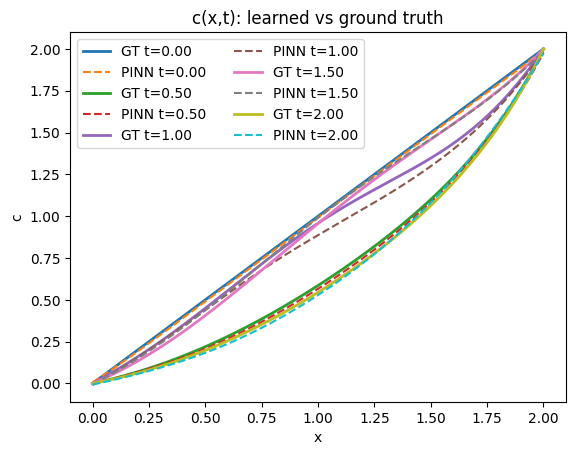

Relative L2 (slices): 0.023909222601487083
MAE (slices): 0.017962566607026165


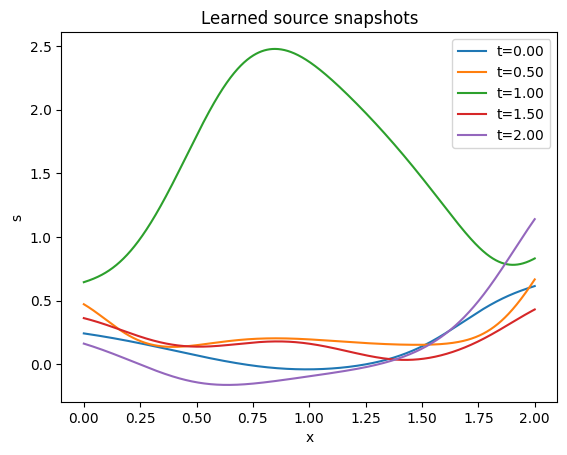

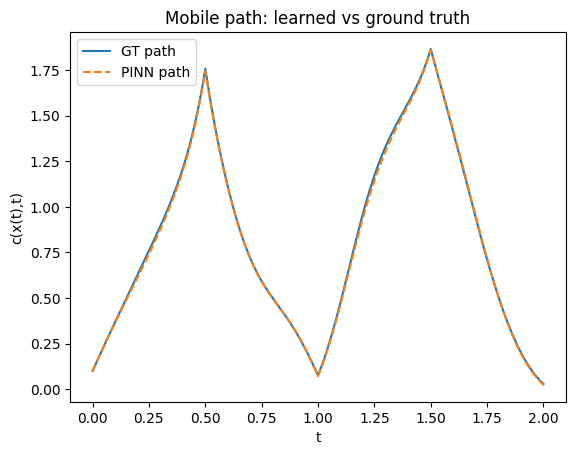

In [10]:
@torch.no_grad()
def predict_on_grid(net: nn.Module, x_grid: np.ndarray, t_grid: np.ndarray, batch: int = 200000) -> np.ndarray:
    TT, XX = np.meshgrid(t_grid, x_grid, indexing='ij')
    Xt = torch.tensor(np.column_stack([XX.ravel(), TT.ravel()]), dtype=torch.float32, device=device)
    preds = []
    for i in range(0, Xt.shape[0], batch):
        preds.append(net(Xt[i:i+batch]).detach().cpu().numpy())
    return np.concatenate(preds, axis=0).reshape(t_grid.size, x_grid.size)

times_eval = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
t_idx_eval = np.clip((times_eval / p.dt).round().astype(int), 0, t.size-1)
t_eval = t[t_idx_eval]

c_pred = predict_on_grid(c_net, x, t_eval)
s_pred = predict_on_grid(s_net, x, t_eval)

# c slices
plt.figure()
for k, tt in enumerate(t_eval):
    plt.plot(x, C[t_idx_eval[k]], label=f"GT t={tt:.2f}", linewidth=2)
    plt.plot(x, c_pred[k], '--', label=f"PINN t={tt:.2f}")
plt.xlabel('x'); plt.ylabel('c'); plt.title('c(x,t): learned vs ground truth')
plt.legend(ncol=2); plt.show()

err = c_pred - C[t_idx_eval]
print('Relative L2 (slices):', np.linalg.norm(err.ravel())/np.linalg.norm(C[t_idx_eval].ravel()))
print('MAE (slices):', np.mean(np.abs(err)))

# source snapshots
plt.figure()
for k, tt in enumerate(t_eval):
    plt.plot(x, s_pred[k], label=f"t={tt:.2f}")
plt.xlabel('x'); plt.ylabel('s'); plt.title('Learned source snapshots')
plt.legend(); plt.show()

# Fit along the path (noiseless reference)
X_path = torch.tensor(np.column_stack([x_path, t_s]), dtype=torch.float32, device=device)
with torch.no_grad():
    c_path_pred = c_net(X_path).cpu().numpy().ravel()

plt.figure()
plt.plot(t_s, c_path_ref, label='GT path')
plt.plot(t_s, c_path_pred, '--', label='PINN path')
plt.xlabel('t'); plt.ylabel('c(x(t),t)')
plt.title('Mobile path: learned vs ground truth')
plt.legend(); plt.show()


## 9) Training curves

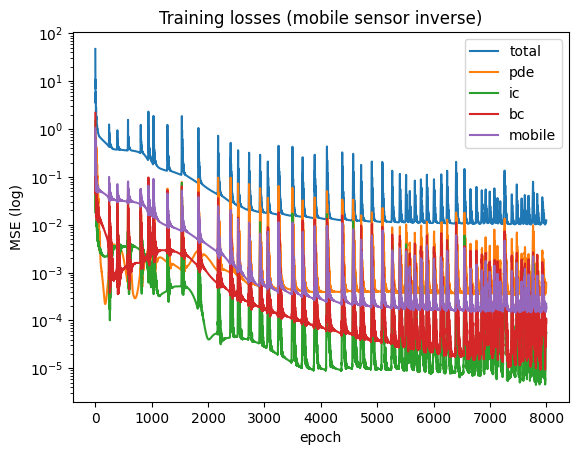

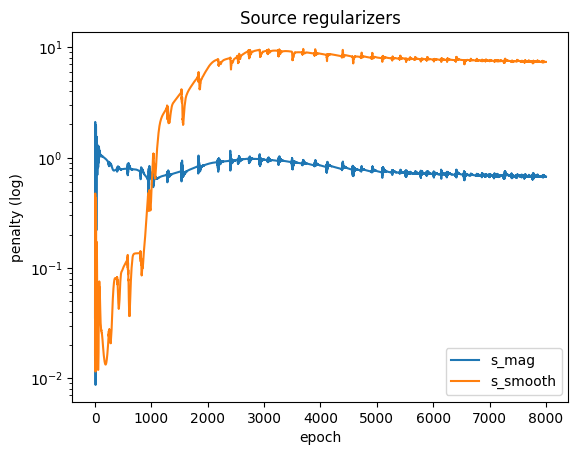

In [11]:
loss_hist = np.array(loss_hist)

plt.figure()
plt.semilogy(loss_hist[:,0], label='total')
plt.semilogy(loss_hist[:,1], label='pde')
plt.semilogy(loss_hist[:,2], label='ic')
plt.semilogy(loss_hist[:,3], label='bc')
plt.semilogy(loss_hist[:,4], label='mobile')
plt.xlabel('epoch'); plt.ylabel('MSE (log)')
plt.title('Training losses (mobile sensor inverse)')
plt.legend(); plt.show()

plt.figure()
plt.semilogy(loss_hist[:,5], label='s_mag')
plt.semilogy(loss_hist[:,6], label='s_smooth')
plt.xlabel('epoch'); plt.ylabel('penalty (log)')
plt.title('Source regularizers')
plt.legend(); plt.show()
